<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT23/blob/main/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Approximation**
**Lovisa Strange**

# **Abstract**

In this report, L2-projection will be used to approximate a function $f(x)$.

#**About the code**

In [ ]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2024 Lovisa Strange (lstrange@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

The modules needed to run this code is presented here.

In [17]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

We want to construct an approximation of the function $f(x),$ that is, we wan to write the function $$
f(x) \approx f_N(x) = \sum_{j=1}^N \alpha_j \phi_j(x)
$$
where $\phi_j$ is the j:th basis vector and $\alpha_j$ is the j:th coefficient. One way to construct these approximation is projection methods.

# **Method**

A projection method is L2 projection. (Methods in Computational Science, p.200, Johan Hoffman)  We have a Hilbert space $L^2$ with an inner product, defined as $$(f,g)_{L^2[a,b]} = \int_a^b f(x)g(x) dx.$$
We can then observe $$(P_Nf,v) = (f,v),$$
which is the projecetion of $P_Nf$ onto the vector space.

We know that since using the basis vectors $\phi_j,$ any vector can be written as $$
v = \sum_{j=0}^N v_j \phi_j,
$$ Then, we know that is enough to look at the effect of the projection on the basis vectors, as shown in the problem solving assignment $$
\sum_{j=1}^N \alpha_j(\phi_j,\phi_i) = (f,\phi_i)
$$
for $i= 1,...,N.$

This can then be written as a matrix equation $$
Ax = b,
$$
where the matrix elements are given by $$
a_{i,j} = (\phi_j,\phi_i) = \int_a^b \phi_j(x)\phi_i(x) dx.
$$
Additionally, the vector elements are given by $$
b_{i} = (f,\phi_i) = \int_a^b f(x)\phi_i(x) dx.
$$

## L2-projection
We use linear local base functions on the interval 0 to 1, so that any interval $$I_k = [x_k, x_{k+1}]$$ has two linear basis vectors $$
\lambda_{k,0} = \begin{cases} 0 \;\; x = x_k \\ 1 \;\; x = x_{k+1} \end{cases}
$$
and
$$
\lambda_{k,1} = \begin{cases} 1 \;\; x = x_k \\ 0 \;\; x = x_{k+1} \end{cases}
$$
This means that the elements of the matrix is 0 in all pairs of intervals that does not overlap, and the vector A is tri-diagonal. More specifically, we get that for the case $k :=i=j$ $$
a_{k,k} = \int_0^1 \phi_k^2 dx = \int_{I_k} \lambda_{k,1}^2dx + \int_{I_{k+1}} \lambda_{k+1,1}^2dx=$$
$$
= \int_{I_k} \frac{(x-x_{k-1})^2}{h^2}dx + \int_{I_{k+1}} \frac{(x_{k+1}-x)^2}{h^2}dx= ... =\frac{2h}{3}
$$

and for the case where $i=j+1$
$$
a_{k,k+1} = \int_0^1 \phi_k\phi_{k+1} dx =  \int_{I_{k+1}} \lambda_{k+1,0} \lambda_{k+1,1}dx=$$
$$
=  \int_{I_{k+1}} \frac{x_{k+1}-x}{h}\frac{x-x_{k}}{h}dx= ... =\frac{h}{6}
$$
and by symmetry
$$a_{k,k-1} = ...= \frac{h}{6}.$$

For the vector, we can approximate the integral with a trapezoidal approximation, so that
$$
\int_a^b f(x) dx ≈ (b-a)\frac{1}{2} (f(a)+f(b))
$$
which gives $$
b_k = \int_0^1 f(x)\phi_kdx = \int_{I_{k}} f(x)\lambda_{k,1}dx+  \int_{I_{k+1}} f(x)\lambda_{k+1,0}dx=
$$
$$
≈ f(x_k)\frac{h}{2}+ f(x_k)\frac{h}{2} = f(x_k)h
$$

However, it is better to loop over the intervals rather than the nodes. Therefore, in each step we can compute the parts of the matrix and vector relating to that interval in a sub-matrix or vector. Then these can be put into the correct place in the global matrix and vector.

The local elements are computed below.

In [18]:
## Computes the matrix element as above, depending on the local index
def find_matrix_element(k,i,j,h,no_of_elements):

  if i==0 and j ==0 and k == 0:

    return 2*h/3

  elif i==1 and j ==1 and k == no_of_elements-1:

    return 2*h/3

  elif j==i-1 or j==i+1:

    return h/6

  else:

    return h/3

In [19]:
## Computes the vector element as above, depending on the local index
def find_vector_element(f,k,i,h,mesh):
  if k==0 and i ==0:
    return f(mesh[k])*h
  elif k== len(mesh)-1 and i==1:
    return f(mesh[k])*h
  elif i == 0:
    return f(mesh[k])*h/2
  else:
    return f(mesh[k+1])*h/2

Then, the elements of the local matrix and vector need to be placed in the right places. This is done by the function below.

In [20]:
## Adds the global matrix in the right place
def add_to_global_matrix(A,A_k,k,no_of_elements):

    if k == no_of_elements-1:
      A[k,k] += A_k[0,0]
    else:
      A[k,k] += A_k[0,0]
      A[k,k+1] += A_k[0,1]
      A[k+1,k] += A_k[1,0]
      A[k+1,k+1] += A_k[1,1]


    return A


In [21]:
## Adds the local vector in the correct place
def add_to_global_vector(b,b_k,k,no_of_elements):
  if k== no_of_elements-1:
    b[k] += b_k[0]
  else:
    b[k] += b_k[0]
    b[k+1] += b_k[1]

  return b

Finally, we can create the matrix global A and vector b by looping through the intervals, and computing the local elements for each interval. This is done in the code below.

In [55]:
## L2-projection, partiliy based on algorithm 9.2, p.203, in Methods in Computational Science, Johan Hoffman

# Input: Function f
# Output: Matrix A, vector b
def L2(f):

  h = 0.001 # step length
  mesh = [i*h for i in range(1000)] # mesh

  A = np.zeros([len(mesh),len(mesh)]) # Empty global matrix and vector
  b = np.zeros([len(mesh)])


  for k in range(len(mesh)):

    q = 2 # number of local base vectors

    b_k = np.zeros((q)) # Creates local matrix and vector
    A_k = np.zeros((q,q))

    for i in range(q): # Compute local elements
      b_k[i] = find_vector_element(f,k,i,h,mesh)
      for j in range(q):
        A_k[i,j] = find_matrix_element(k,i,j,h,len(mesh))

    add_to_global_vector(b,b_k,k,len(mesh)) # Add local elements to global matrix and vector
    add_to_global_matrix(A,A_k,k,len(mesh))

  return A,b


# **Results**
In this section, the results from the algorithm presented in the last section are shown.

## L2-projecion
We can compare our approximation of the function $f$ by comparing to the exact solution. We define the function f to be approximated as


In [56]:
def f(x):
  return np.cos(x)

Using the A and B computed with the algorithm above, we get the values of $\alpha_j,$ and therefore the values that we approximate the function to have in those points. We can look at the difference between $f(x_i)$ computed for all the nodes and the approximated values in the same points and see if these are small. If they are, the approximation is close to the actual values.

We can also plot the real function and compare it to the approximated values.

alpha_j*phi_j(x_j) - f(x_j) = 
 [ 2.67949270e-01 -7.17965791e-02  1.92380467e-02 -5.15460776e-03
  1.38138431e-03 -3.69929488e-04  9.93336288e-05 -2.64050456e-05
  7.28652911e-06 -1.74110289e-06  6.77841853e-07  2.96853897e-08
  2.03356005e-07  1.56818507e-07  1.69285384e-07  1.65941875e-07
  1.66834535e-07  1.66591905e-07  1.66653264e-07  1.66632959e-07
  1.66634323e-07  1.66629671e-07  1.66626419e-07  1.66622581e-07
  1.66618688e-07  1.66614599e-07  1.66610351e-07  1.66605934e-07
  1.66601351e-07  1.66596602e-07  1.66591686e-07  1.66586604e-07
  1.66581355e-07  1.66575939e-07  1.66570357e-07  1.66564608e-07
  1.66558692e-07  1.66552610e-07  1.66546362e-07  1.66539947e-07
  1.66533365e-07  1.66526617e-07  1.66519702e-07  1.66512621e-07
  1.66505373e-07  1.66497959e-07  1.66490378e-07  1.66482631e-07
  1.66474717e-07  1.66466637e-07  1.66458391e-07  1.66449978e-07
  1.66441398e-07  1.66432652e-07  1.66423740e-07  1.66414661e-07
  1.66405416e-07  1.66396004e-07  1.66386426e-07  1.663766

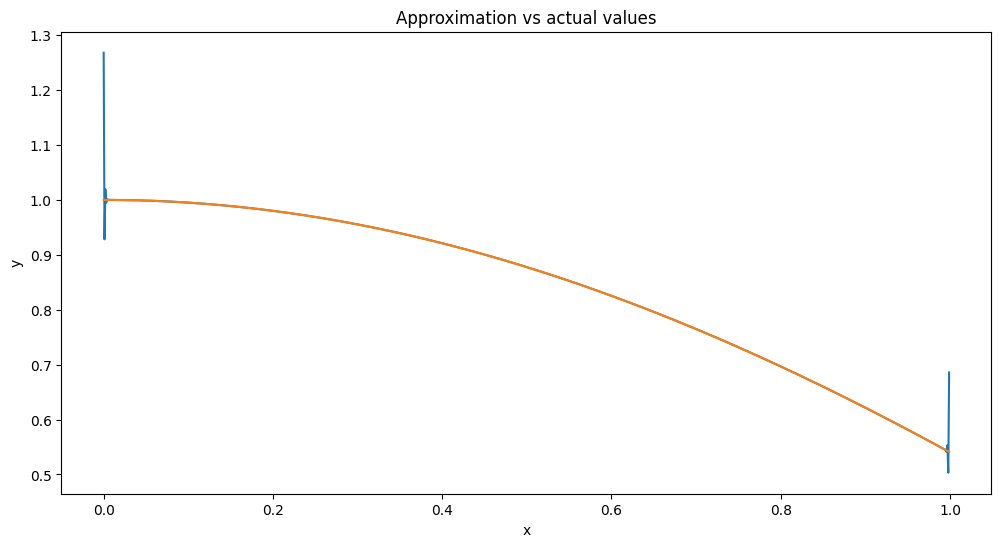

In [57]:
A,b = L2(f)
solution = np.linalg.solve(A,b)

x_values = [i*0.001 for i in range(1000)]
f_values = [f(i*0.001) for i in range(1000)]


print("alpha_j*phi_j(x_j) - f(x_j) = \n", solution-f(x_values))

plt.figure(figsize=(12,6))
plt.plot(x_values,solution)
plt.plot(x_values,f_values)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Approximation vs actual values')
plt.show()

We can see that the difference between the approximation and the real function is small, exept for in the end points. Also, the difference becomes smaller when decresing the iterval size.

# **Discussion**

The result is mostly as expected. Since the difference between the approximation and the function becomes smaller when decreasing the step size, we can see that the result converges to the actual function.